### Import Libraries & Load Data

In [1]:
from google.colab import files
uploaded = files.upload()

Saving GoogleReview_data_cleaned.csv to GoogleReview_data_cleaned (1).csv


In [5]:
import pandas as pd
import numpy as np

# Load the dataset (adjust path if needed)
df = pd.read_csv('/content/GoogleReview_data_cleaned.csv')

# Quick check
df.head()

,Author,Rating,Review,Restaurant,Location
0,Jia Pin Lee,4.0,Came here for the High Tea. Great service espe...,Cuisines Restaurant,Ipoh
1,Chui Yi Lum,2.0,"5 stars for the service, even though some of t...",Cuisines Restaurant,Ipoh
2,liezel wong,1.0,"Hi, thank you for your service. But! i feel so...",Cuisines Restaurant,Ipoh
3,Nazri Nor,1.0,I have the worse buffer dinner ever so far. Th...,Cuisines Restaurant,Ipoh
4,Fakru Imran's Channel,5.0,"That's are Known 5 Elmark "" 9H72 "" & KDK "" 3 K...",Cuisines Restaurant,Ipoh


### Label Sentiment Based on Rating

In [6]:
def label_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

# Apply to DataFrame
df['Sentiment'] = df['Rating'].apply(label_sentiment)

# Preview the result
df[['Rating', 'Sentiment', 'Review']].head(10)


,Rating,Sentiment,Review
0,4.0,Positive,Came here for the High Tea. Great service espe...
1,2.0,Negative,"5 stars for the service, even though some of t..."
2,1.0,Negative,"Hi, thank you for your service. But! i feel so..."
3,1.0,Negative,I have the worse buffer dinner ever so far. Th...
4,5.0,Positive,"That's are Known 5 Elmark "" 9H72 "" & KDK "" 3 K..."
5,2.0,Negative,I just came back from there. 2 adults and 4 yo...
6,2.0,Negative,Restaurant looks nice but taste is bad. I had ...
7,4.0,Positive,"Pros: ambience is great with lake view, good a..."
8,1.0,Negative,We went to this place after reviews on Tripadv...
9,4.0,Positive,"the restaurant is located inside the hotel, th..."


### Extract Aspects Using spaCy (Dependency Parsing)

In [7]:
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Extract Aspect–Opinion Pairs from Each Review

In [9]:
aspect_opinion_pairs = []

sample_reviews = df['Review'].dropna().head(30)

for review in sample_reviews:
    doc = nlp(review)
    for token in doc:
        if token.pos_ == "NOUN":
            for child in token.children:
                if child.pos_ in ["ADJ", "VERB"]:
                    aspect_opinion_pairs.append((token.text.lower(), child.text.lower()))

# Show sample aspect-opinion pairs
import pandas as pd
aspect_df = pd.DataFrame(aspect_opinion_pairs, columns=["Aspect", "Opinion"])
aspect_df.head(10)


,Aspect,Opinion
0,service,great
1,service,great
2,stars,need
3,experience,overall
4,love,more
5,day,next
6,dinner,worse
7,dishes,salty
8,meat,bbq
9,experience,bad


### A. View Most Frequent Aspects and Opinions

In [10]:
# Most common aspects
top_aspects = aspect_df['Aspect'].value_counts().head(15)
print("🔸 Top Aspects:\n", top_aspects)

# Most common opinions
top_opinions = aspect_df['Opinion'].value_counts().head(15)
print("\n🔹 Top Opinions:\n", top_opinions)

🔸 Top Aspects:
 Aspect
food              7
restaurant        6
experience        5
sum               5
establishments    4
service           3
dishes            3
duck              2
variety           2
day               2
dinner            1
love              1
stars             1
kipas             1
weather           1
Name: count, dtype: int64

🔹 Top Opinions:
 Opinion
dim          5
great        4
good         3
best         3
hot          2
free         2
halal        2
friendly     2
nice         2
overall      1
need         1
known        1
expensive    1
more         1
next         1
Name: count, dtype: int64


###  B. Group Aspects by Sentiment

In [11]:
# Create a temporary DataFrame with review + sentiment
sent_df = df[['Review', 'Sentiment']].dropna().head(30)

# Re-run aspect-opinion extraction, this time keeping track of sentiment
aspect_sentiment_pairs = []

for idx, row in sent_df.iterrows():
    doc = nlp(row['Review'])
    for token in doc:
        if token.pos_ == "NOUN":
            for child in token.children:
                if child.pos_ in ["ADJ", "VERB"]:
                    aspect_sentiment_pairs.append((token.text.lower(), child.text.lower(), row['Sentiment']))

# Turn into DataFrame
sentiment_df = pd.DataFrame(aspect_sentiment_pairs, columns=["Aspect", "Opinion", "Sentiment"])

# Top 10 positive aspects
positive_aspects = sentiment_df[sentiment_df["Sentiment"] == "Positive"]["Aspect"].value_counts().head(10)
print("✅ Top Positive Aspects:\n", positive_aspects)

# Top 10 negative aspects
negative_aspects = sentiment_df[sentiment_df["Sentiment"] == "Negative"]["Aspect"].value_counts().head(10)
print("\n❌ Top Negative Aspects:\n", negative_aspects)


✅ Top Positive Aspects:
 Aspect
food              7
restaurant        6
sum               5
establishments    4
service           3
dishes            2
duck              2
parking           1
day               1
sunshine          1
Name: count, dtype: int64

❌ Top Negative Aspects:
 Aspect
experience    5
stars         1
love          1
day           1
dinner        1
dishes        1
meat          1
children      1
week          1
variety       1
Name: count, dtype: int64


### C. Word Cloud for Aspects and Opinions

In [12]:
!pip install wordcloud

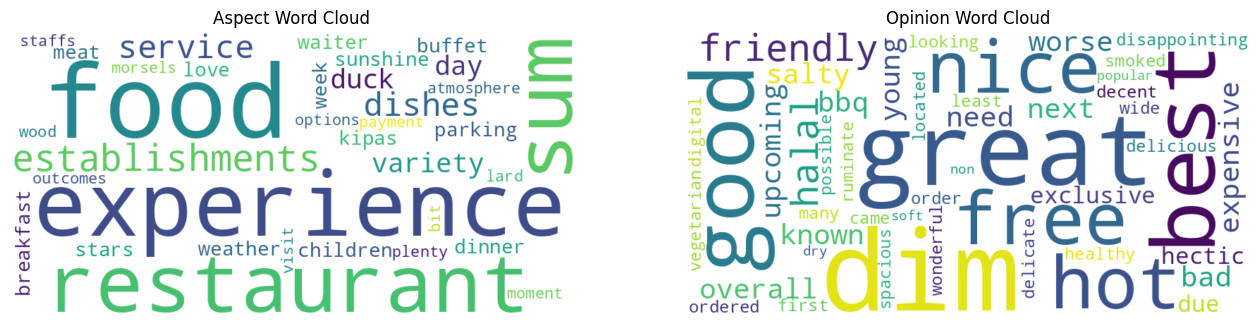

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate aspect word cloud
aspect_text = ' '.join(aspect_df['Aspect'])
aspect_wc = WordCloud(width=800, height=400, background_color='white').generate(aspect_text)

# Generate opinion word cloud
opinion_text = ' '.join(aspect_df['Opinion'])
opinion_wc = WordCloud(width=800, height=400, background_color='white').generate(opinion_text)

# Plot them side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(aspect_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Aspect Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(opinion_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Opinion Word Cloud')

plt.show()